In [2]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [3]:
# Hyperparmeters
batch_size = 128
learning_rate = 0.01
momentum=0.5
epoch=10
# Other constants
input_size = 28*28
num_classes = 10

In [4]:
# Разделите данные на 3 выборке (обучающая, валидационная, тестовая)

dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)

train_ds, val_ds = random_split(dataset, [50000, 10000])
test_ds = MNIST(root='data/', train=False, transform=transforms.ToTensor())

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_ds, batch_size*2)

In [5]:
# Выберите метрику для оценки классификатора
# Постройте классификатор цифр. Используйте валидационную выборку для выбора модели/оптимизации гиперпараметров. 


class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        self.linear1 = nn.Linear(input_size, 128)
        self.linear2 = nn.Linear(128, 64)
        self.linear3 = nn.Linear(64, num_classes)

       
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        xb = F.relu(self.linear1(xb))
        xb = F.relu(self.linear2(xb))
        xb = self.linear3(xb)
        return xb
   
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  
        loss = F.cross_entropy(out, labels) # Расчёт потерь
        return loss
   
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   # Расчёт потерь
        acc = accuracy(out, labels)           # Расчёт точности
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
    
    def validation_step_train(self, batch):
        images, labels = batch
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   # Расчёт потерь
        acc = accuracy(out, labels)           # Расчёт точности
        return {'train_loss': loss.detach(), 'train_acc': acc.detach()}
       
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Средняя потеря
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Средняя точность
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def validation_epoch_end_train(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Средняя потеря
        batch_accs = [x['train_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Средняя точность
        return {'train_loss': epoch_loss.item(), 'train_acc': epoch_acc.item()}
   
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
        
    def epoch_end_train(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}".format(epoch, result['train_loss'], result['train_acc']))
   

model = MnistModel()
print(model)

MnistModel(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)


In [6]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [7]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def evaluate_train(model, train_loader):
    outputs = [model.validation_step_train(batch) for batch in train_loader]
    return model.validation_epoch_end_train(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    history_train = []
    
    optimizer = opt_func(model.parameters(), lr, momentum=momentum)
    for epoch in range(epochs):
        # Обучение
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Валидация
        result = evaluate(model, val_loader)
        result_train = evaluate_train(model, train_loader)
        model.epoch_end(epoch, result)
        model.epoch_end_train(epoch, result_train)
        history.append(result)
        history_train.append(result_train)
    return history, history_train

In [8]:
evaluate(model, val_loader)

{'val_loss': 2.3029403686523438, 'val_acc': 0.0927734375}

In [9]:
history, history_train = fit(epoch, learning_rate, model, train_loader, val_loader)

Epoch [0], val_loss: 1.0838, val_acc: 0.7528
Epoch [0], train_loss: 1.0711, train_acc: 0.7639
Epoch [1], val_loss: 0.4972, val_acc: 0.8688
Epoch [1], train_loss: 0.4842, train_acc: 0.8695
Epoch [2], val_loss: 0.4054, val_acc: 0.8863
Epoch [2], train_loss: 0.3889, train_acc: 0.8925
Epoch [3], val_loss: 0.3693, val_acc: 0.8964
Epoch [3], train_loss: 0.3485, train_acc: 0.9006
Epoch [4], val_loss: 0.3471, val_acc: 0.9018
Epoch [4], train_loss: 0.3273, train_acc: 0.9066
Epoch [5], val_loss: 0.3230, val_acc: 0.9083
Epoch [5], train_loss: 0.3006, train_acc: 0.9140
Epoch [6], val_loss: 0.3054, val_acc: 0.9126
Epoch [6], train_loss: 0.2830, train_acc: 0.9193
Epoch [7], val_loss: 0.2917, val_acc: 0.9157
Epoch [7], train_loss: 0.2684, train_acc: 0.9232
Epoch [8], val_loss: 0.2798, val_acc: 0.9199
Epoch [8], train_loss: 0.2550, train_acc: 0.9282
Epoch [9], val_loss: 0.2670, val_acc: 0.9217
Epoch [9], train_loss: 0.2418, train_acc: 0.9314


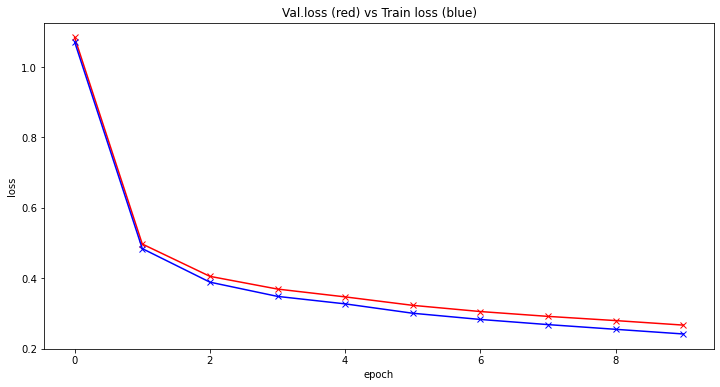

In [10]:

val_loss = [r['val_loss'] for r in history]
loss = [r['train_loss'] for r in history_train]
plt.figure(figsize=(12,6))
plt.plot(val_loss, '-x', c='r')
plt.plot(loss, '-x', c='b')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Val.loss (red) vs Train loss (blue)');


In [11]:
result = evaluate(model, test_loader)
result #проверка на тестовой выборке

{'val_loss': 0.2389499843120575, 'val_acc': 0.933886706829071}

In [12]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


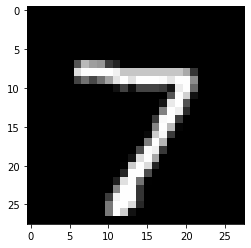

In [13]:
img, label = test_ds[0] #Пример успешного предсказания
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

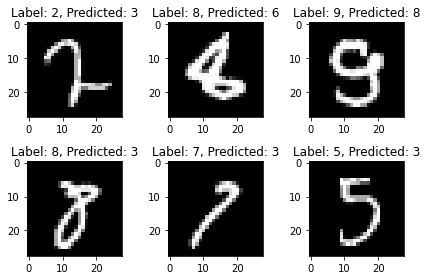

In [14]:
# На валидационной выборке отобразите несколько примеров, на которых классификатор не справляется с задачей.

imcount = 0

for i in range(len(val_ds)):
    img, label = val_ds[i]
    prediction = predict_image(img, model)
    if label != prediction:
        if imcount<6:
            plt.subplot(2,3,imcount+1)
            plt.tight_layout()
            imcount+=1;
            plt.imshow(img[0], cmap='gray')
            plt.title(f'Label: {label}, Predicted: {predict_image(img, model)}')
        else:
            break

plt.show()



In [15]:
#  Выведите classification_report на тестовой выборке.

cls_data = [[],[]]

for i in range(len(test_ds)):
    img, label = test_ds[i]
    prediction = predict_image(img, model)
    cls_data[0].append(label)
    cls_data[1].append(prediction)


from sklearn.metrics import classification_report

print(classification_report(cls_data[0], cls_data[1]))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       980
           1       0.97      0.98      0.97      1135
           2       0.92      0.93      0.92      1032
           3       0.92      0.92      0.92      1010
           4       0.93      0.94      0.93       982
           5       0.92      0.89      0.91       892
           6       0.93      0.96      0.94       958
           7       0.94      0.93      0.94      1028
           8       0.93      0.88      0.90       974
           9       0.93      0.90      0.92      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [16]:
# Определите самые часто перепутываемые пары цифр.(Проверял на всём датасете)

n = 10
m = 10

cls_err = [[0] * m for i in range(n)]

for i in range(len(dataset)):
    img, label = dataset[i]
    prediction = predict_image(img, model)
    if label != prediction:
        cls_err[label][prediction]+=1

import numpy as np

cls_err_np = np.array(cls_err)

def mx_elem(a):
    max_elem = a[0][0]
    for i in range(len(a)):
        for j in range(len(a[i] )):
             if a[i][j] > max_elem:
                max_elem =  a[i][j]

    list_index_max =[ (i,j) for i in range(len(a))  for j in range(len(a[i])) if a[i][j]  == max_elem]
    line, column = list_index_max[0]
    return [line,column,max_elem]

def mx_pairs(a):
    a = a + np.transpose(a)
    a = np.triu(a)
    for i in range(5):
        elem = mx_elem(a)
        print('Чаще всего путают: ')
        print(f'Цифры {elem[0]} и {elem[1]}: {elem[2]} количество раз')
        a[elem[0]][elem[1]]=0


In [17]:
mx_pairs(cls_err_np)

Чаще всего путают: 
Цифры 4 и 9: 389 количество раз
Чаще всего путают: 
Цифры 3 и 5: 336 количество раз
Чаще всего путают: 
Цифры 7 и 9: 255 количество раз
Чаще всего путают: 
Цифры 2 и 3: 208 количество раз
Чаще всего путают: 
Цифры 5 и 8: 205 количество раз
